In [418]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [460]:
dirname = "../002_Freq1-50MHz_Delta1MHz_AntennaLength6m_AntennaAngle30deg_LanderHeight2m/ElectricField"
filename = "ElectricFieldPlot_Freq10MHz_AntennaLength6m_AntennaAngle30deg_LanderHeight2m_in_phase.csv"
filenameperp = "ElectricFieldPlot_Freq10MHz_AntennaLength6m_AntennaAngle30deg_LanderHeight2m_perpendicular_in_phase.csv"
fullname = dirname +'/'+filename

In [528]:
class SingleFrequencyBeam:
    def __init__ (self,fname):
        dataR = np.recfromcsv(fname, delimiter=',')
        dataI = np.recfromcsv(fname.replace("in_phase","out_of_phase"), delimiter=',')
        thetadeg = dataR['thetadeg']
        phideg = dataR['phideg']
        Ntheta = len(set(thetadeg))
        Nphi = len(set(phideg))
        dtheta = 180/(Ntheta-1)
        dphi = 360/(len(set(phideg))-1)
        thetandx = ((thetadeg-0)/dtheta).astype(int)
        phindx = ((phideg-(-180))/dphi).astype(int)
        ## make a list of nans and fill it
        self.E = np.zeros((Ntheta,Nphi,3),np.complex128)+np.nan ## Make them nan to see if they are filled
        self.Ei = np.zeros((Ntheta,Nphi,3),np.complex128)+np.nan ## Make them nan to see if they are filled
        Ereal = np.array([dataR['rerexmv'],dataR['rereymv'],dataR['rerezmv']]).T
        Eimag = np.array([dataR['imrexmv'],dataR['imreymv'],dataR['imrezmv']]).T 
        self.E[thetandx,phindx]=Ereal + 1j*Eimag
        Ereal = np.array([dataI['rerexmv'],dataI['rereymv'],dataI['rerezmv']]).T
        Eimag = np.array([dataI['imrexmv'],dataI['imreymv'],dataI['imrezmv']]).T 
        self.Ei[thetandx,phindx]=Ereal + 1j*Eimag

        ## make sure all nans have been fileld
        assert(not np.any(np.isnan(self.E)))
        self.theta_deg = np.arange(Ntheta)*2
        self.phi_deg = np.arange(Nphi)*2
        self.theta = self.theta_deg/180*np.pi
        self.phi = self.phi_deg/180*np.pi
        self.direct= np.array([np.sin(self.theta[None,:])*np.cos(self.phi[:,None]),
                     np.sin(self.theta[None,:])*np.sin(self.phi[:,None]),
                     np.cos(self.theta[None,:])*np.ones(Nphi)[:,None]]).T
        self.dphi = dphi
        self.dtheta = dtheta
        self.Nphi = Nphi
        self.Ntheta = Ntheta
    
    def rotate(self,deg):
        assert (deg in [45,-45,90,-90,135,-135,270,-270,180,-180])
        rad = deg/180*np.pi
        cosrad = np.cos(rad)
        sinrad = np.sin(rad)
        assert (deg%self.dphi==0)
        m = int(deg // self.dphi)
        E = np.hstack ((self.E[:,m:,:],self.E[:,1:m+1,:]))
        Ei = np.hstack ((self.Ei[:,m:,:],self.Ei[:,1:m+1,:]))
        rotmat = np.array(([[cosrad, sinrad, 0],[-sinrad,cosrad,0],[0,0,1]]))
        E = np.einsum('ij,abj',rotmat,E)
        Ei = np.einsum('ij,abj',rotmat,Ei)
        return E,Ei
     
    def flip_over_yz(self):
        m = int(90 // self.dphi)
        n = int(180 // self.dphi)
        o = int(270 // self.dphi)
        print(m,n,o)
        E = np.hstack ((self.E[:,n:0:-1,:],self.E[:,self.Nphi:n-1:-1,:]))
        E[:,:,0]*=-1 ## X flips over
        Ei = np.hstack((self.E[:,n:0:-1,:],self.E[:,self.Nphi:n-1:-1,:]))
        Ei[:,:,0]*=-1 ## X flips over
        
        return E, Ei
        
def plotE(field, noabs=False):
    plt.figure(figsize=(15,10))
    for i in range(3):
        plt.subplot(1,3,i+1)
        ax = plt.gca()
        plt.title ('XYZ'[i])
        if noabs:
            im = ax.imshow(field[:,:,i])
        else:
            im=ax.imshow(np.abs(field[:,:,i]),interpolation='nearest',extent=[0,360,180,0],origin='upper')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)



In [529]:
b = SingleFrequencyBeam(fullname)
bperp = SingleFrequencyBeam(dirname +'/'+filenameperp)

In [530]:
Er, Eri = b.rotate(180)
Ef, Efi = b.flip_over_yz()

45 90 135


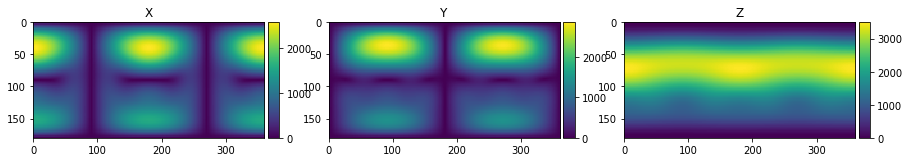

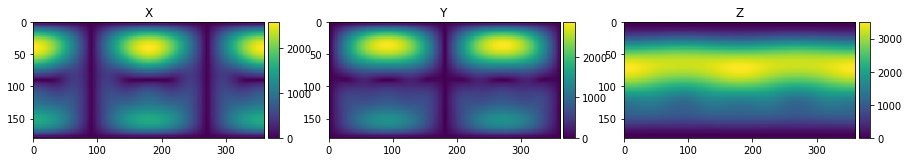

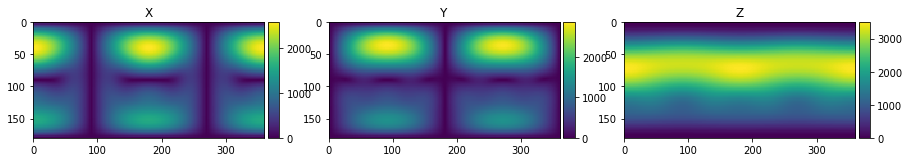

In [531]:
plotE(b.E)
plotE(Er)
plotE(Ef)

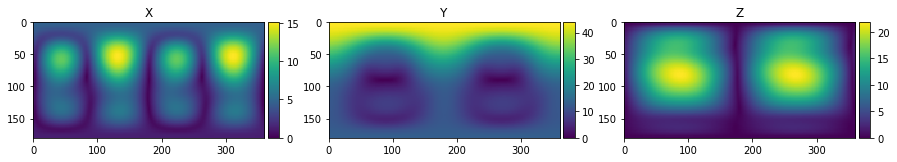

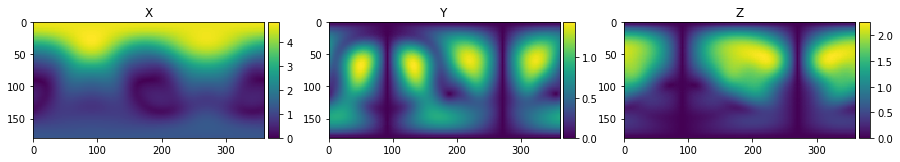

In [532]:
plotE(Er-b.E)
plotE(Ef-b.E)


In [550]:
E1 = (b.Ei-b.E)/2
E2 = (b.Ei-E1)
bx = SingleFrequencyBeam(fullname)
bx.E = E2
#bx.E = bx.flip_over_yz()[0]
bt=SingleFrequencyBeam(fullname)
bt.E = E1
bt.E = bt.E + bt.rotate(180)[0]

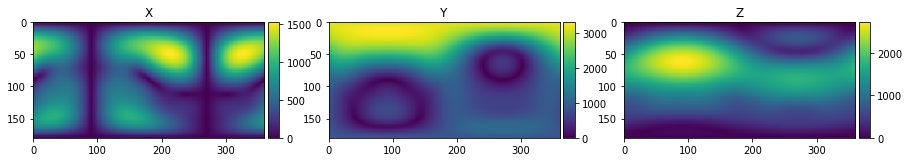

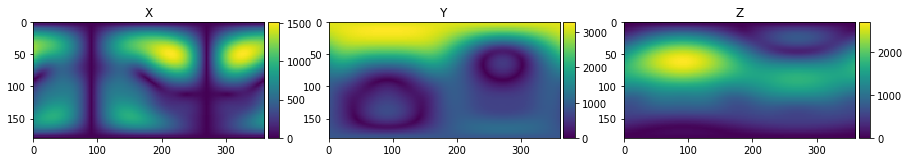

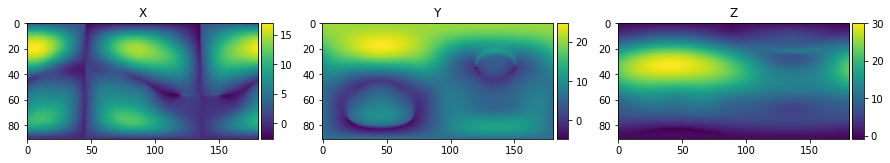

In [551]:
plotE(E1)
plotE(bx.rotate(180)[0])
plotE(np.abs(E1)-np.abs(bx.rotate(180)[0]),noabs=True)

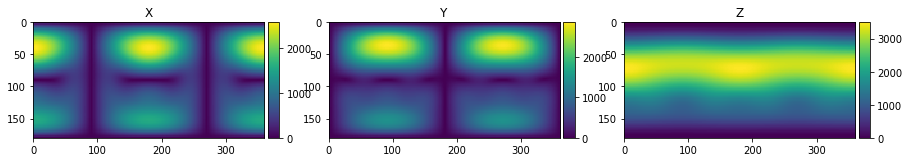

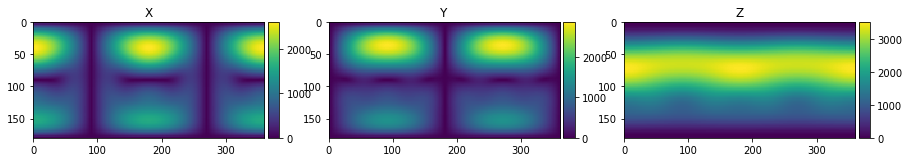

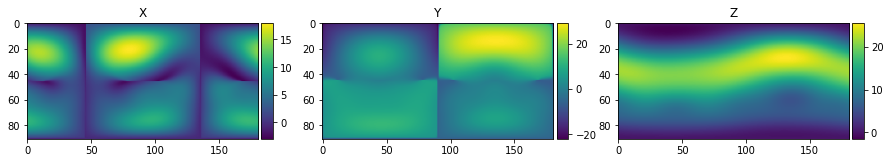

In [552]:
plotE(b.E)
plotE(bt.E)
plotE(np.abs(bt.E)-np.abs(b.E),noabs=True)


In [560]:
bp = SingleFrequencyBeam(fullname)
bp.E = E2
bp.E = E2+bp.rotate(-90)[0]

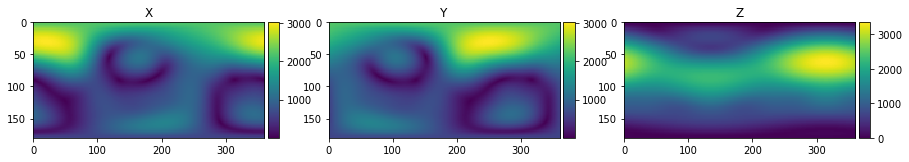

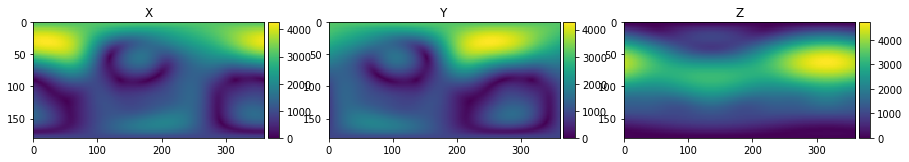

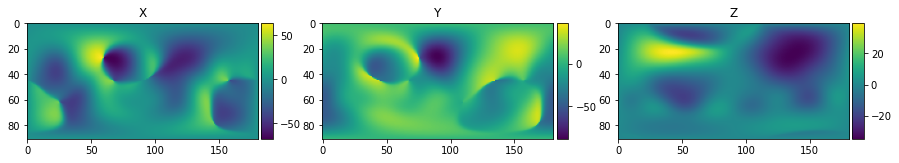

In [561]:
plotE(bp.E/np.sqrt(2))
plotE(bperp.E)
plotE(np.abs(bperp.E)-np.abs(bp.E),noabs=True)